<a href="https://colab.research.google.com/github/mavillan/yolanda/blob/main/notebooks/train_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
## notebook config

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            35G        959M         31G        1.1M        2.3G         33G
Swap:            0B          0B          0B


In [6]:
!pip install --upgrade category_encoders > /dev/null 2>&1
!pip install --upgrade tsforest > /dev/null 2>&1
!pip install --upgrade lightgbm > /dev/null 2>&1

In [ ]:
%%bash
git clone --recursive https://github.com/microsoft/LightGBM ; cd LightGBM
mkdir build
#export CMAKE_CXX_FLAGS='-O3 -mtune=native'
cmake -DUSE_GPU=1
make -j$(nproc)
cd ./python-package/
python setup.py install --precompile

***

In [7]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import category_encoders as ce
import lightgbm as lgb
from tsforest.forecast import LightGBMForecaster

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
class RMSSE():
    def __init__(self, valid_dataframe, scales_dataframe):
        self.valid_dataframe = valid_dataframe
        self.scales_dataframe = scales_dataframe

    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        valid_dataframe["ypred"] = predictions
        valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        mse = valid_dataframe.groupby("sku")["sq_error"].mean().reset_index(name="mse")
        mrg = pd.merge(mse, self.scales_dataframe, how="inner", on="sku")
        return mrg.eval("sqrt(mse)/scale").mean()

    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "rmsse", metric, False

***
## data preparation

In [10]:
!kaggle datasets download -d mavillan/meli-2021 --force --unzip
!ls -halt 

 95% 213M/225M [00:01<00:00, 160MB/s]
100% 225M/225M [00:01<00:00, 126MB/s]
total 315M
drwxr-xr-x 1 root root 4.0K Aug  8 05:20 .
-rw-r--r-- 1 root root 169K Aug  8 05:20 unpredictable.csv
-rw-r--r-- 1 root root  78M Aug  8 05:20 train.parquet
-rw-r--r-- 1 root root 222M Aug  8 05:20 test.parquet
-rw-r--r-- 1 root root  16M Aug  8 05:20 scales.csv
drwx------ 5 root root 4.0K Aug  8 05:19 drive
drwxr-xr-x 1 root root 4.0K Aug  8 05:03 ..
drwxr-xr-x 1 root root 4.0K Jul 16 13:20 sample_data
drwxr-xr-x 4 root root 4.0K Jul 16 13:19 .config


In [11]:
dataset = pd.read_parquet("./train.parquet")
dataset.rename({"date":"ds", "sold_quantity":"y"}, axis=1, inplace=True)
dataset

,ds,sku,y,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,available,item_domain_id,item_id,site_id,product_id,product_family_id
0,2021-02-01,0,0,172.789993,REA,classic,cross_docking,free_shipping,0.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
1,2021-02-02,0,0,172.789993,REA,classic,cross_docking,free_shipping,0.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
2,2021-02-03,0,0,179.990005,REA,classic,cross_docking,free_shipping,872.650024,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
3,2021-02-04,0,0,179.990005,REA,classic,cross_docking,free_shipping,1440.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
4,2021-02-05,0,0,179.990005,REA,classic,cross_docking,free_shipping,1440.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38994039,2021-03-27,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
38994040,2021-03-28,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
38994041,2021-03-29,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
38994042,2021-03-30,660915,0,99.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None


In [12]:
unpredictable = pd.read_csv("unpredictable.csv")
scales = pd.read_csv("scales.csv")

dataset = dataset.query("sku not in @unpredictable.sku").reset_index(drop=True)
dataset

,ds,sku,y,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,available,item_domain_id,item_id,site_id,product_id,product_family_id
0,2021-02-01,0,0,172.789993,REA,classic,cross_docking,free_shipping,0.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
1,2021-02-02,0,0,172.789993,REA,classic,cross_docking,free_shipping,0.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
2,2021-02-03,0,0,179.990005,REA,classic,cross_docking,free_shipping,872.650024,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
3,2021-02-04,0,0,179.990005,REA,classic,cross_docking,free_shipping,1440.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
4,2021-02-05,0,0,179.990005,REA,classic,cross_docking,free_shipping,1440.000000,1,MLB-SNEAKERS,492155,MLB,None,MLB15832732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37502342,2021-03-27,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
37502343,2021-03-28,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
37502344,2021-03-29,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
37502345,2021-03-30,660915,0,99.989998,MEX,classic,fulfillment,paid_shipping,0.000000,1,MLM-SURGICAL_MASKS,423179,MLM,None,None


In [13]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": ("y", ce.CatBoostEncoder, None),
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

In [14]:
dataset.loc[:,categorical_features.keys()].nunique()

sku                       635633
currency                       4
listing_type                   2
shipping_logistic_type         3
shipping_payment               2
item_domain_id              8372
item_id                   497537
site_id                        3
product_id                 15237
product_family_id          28817
dtype: int64

In [15]:
dataset.groupby("site_id")["sku"].nunique()

site_id
MLA     55514
MLB    323896
MLM    256223
Name: sku, dtype: int64

***
## model config

In [36]:
# model configuration
model_params = {
    'objective':'huber',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'boost_from_average': False,
    'force_row_wise': True,
    #'device_type': 'gpu',
    #'num_gpu' : 1,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
}

***
## Model assessment

---------------------------------------------------------------------------
Training model for site: MLA
Mem. usage decreased to 149.01 Mb (43.3% reduction)
Mem. usage decreased to 112.77 Mb (51.0% reduction)
Elapsed time for processing features: 0.603321357568105 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 1609906, number of used features: 15
[LightGBM] [Warning] Disabling boost_from_average in regression_l1 may cause the slow convergence
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.821899
[100]	valid_0's rmsse: 0.813091
[150]	valid_0's rmsse: 0.810732
[200]	valid_0's rmsse: 0.809509
[250]	valid_0's rmsse: 0.809162
[300]	valid_0's rmsse: 0.808835
[350]	valid_0's rmsse: 0.808472
[400]	valid_0's rmsse: 0.808143
[450]	valid_0's rmsse: 0.807935
[500]	valid_0's rmsse: 0.807826
[550]	valid_0's rmsse: 0.807683
[600]	valid_0's rmsse: 0.807627
[650]	valid_0's rmsse: 0.807571
[700]	valid_0's rmsse: 0.807

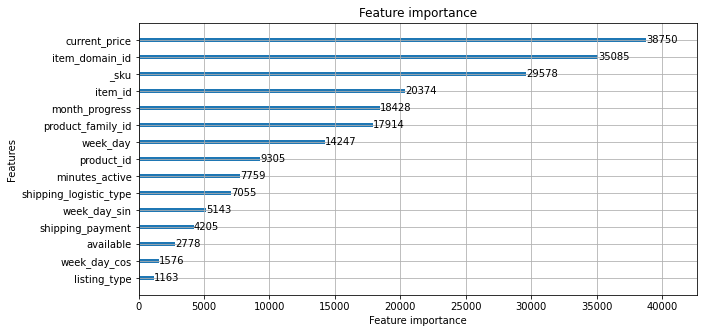

---------------------------------------------------------------------------
Training model for site: MLB
Mem. usage decreased to 956.01 Mb (40.9% reduction)
Mem. usage decreased to 657.94 Mb (51.0% reduction)
Elapsed time for processing features: 2.525306542714437 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 9392984, number of used features: 15
[LightGBM] [Warning] Disabling boost_from_average in regression_l1 may cause the slow convergence
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.886601
[100]	valid_0's rmsse: 0.877059
[150]	valid_0's rmsse: 0.874549
[200]	valid_0's rmsse: 0.873516
[250]	valid_0's rmsse: 0.872285
[300]	valid_0's rmsse: 0.871371
[350]	valid_0's rmsse: 0.871178
[400]	valid_0's rmsse: 0.871077
[450]	valid_0's rmsse: 0.870994
[500]	valid_0's rmsse: 0.870831
[550]	valid_0's rmsse: 0.870772
[600]	valid_0's rmsse: 0.870727
[650]	valid_0's rmsse: 0.870633
Early stopping, best iterati

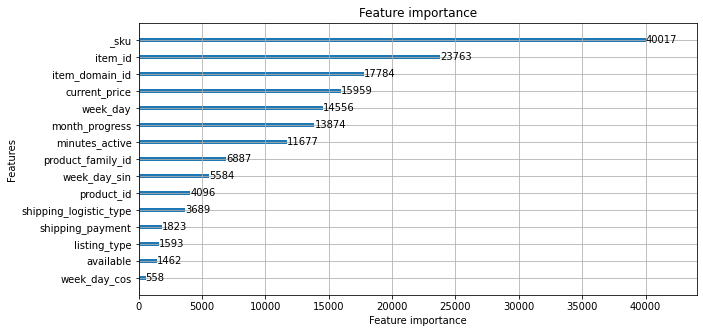

---------------------------------------------------------------------------
Training model for site: MLM
Mem. usage decreased to 823.12 Mb (38.9% reduction)
Mem. usage decreased to 520.47 Mb (51.0% reduction)
Elapsed time for processing features: 2.2643884976704913 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 7430467, number of used features: 15
[LightGBM] [Warning] Disabling boost_from_average in regression_l1 may cause the slow convergence
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.8067
[100]	valid_0's rmsse: 0.799478
[150]	valid_0's rmsse: 0.798036
[200]	valid_0's rmsse: 0.797222
[250]	valid_0's rmsse: 0.797148
[300]	valid_0's rmsse: 0.796922
[350]	valid_0's rmsse: 0.796752
[400]	valid_0's rmsse: 0.796505
[450]	valid_0's rmsse: 0.796239
[500]	valid_0's rmsse: 0.796095
[550]	valid_0's rmsse: 0.796032
[600]	valid_0's rmsse: 0.795986
[650]	valid_0's rmsse: 0.795892
[700]	valid_0's rmsse: 0.7958

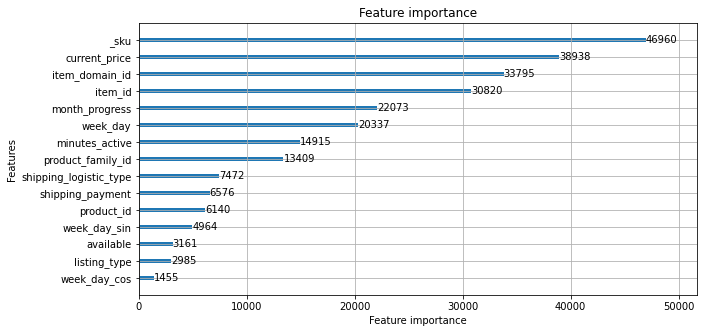

In [34]:
# train with l1
models_by_site = list()

for site in ["MLA","MLB","MLM"]:
    
    print("-"*75)
    print(f"Training model for site: {site}")
    model = LightGBMForecaster(**model_kwargs)

    tic = time.time()
    skus_both = set(dataset.query("ds <= '2021-03-01'").sku) & set(dataset.query("ds > '2021-03-01'").sku)
    train_data = dataset.query("site_id == @site & sku in @skus_both").reset_index(drop=True)
    valid_idx = train_data.query("ds > '2021-03-01'").index
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    lgb.plot_importance(model.model.model, figsize=(10,5))
    plt.show()


In [35]:
# results with l1
errors = list()
sites = ["MLA","MLB","MLM"]

for site,model in zip(sites,models_by_site):
    error = model.model.model.best_score["valid_0"]["rmsse"]
    errors.append(error)
    print(site, f"error: {error}")

print(f"AVG error: {np.mean(errors)}")

MLA error: 0.8075456349601458
MLB error: 0.870631475725776
MLM error: 0.795401472433308
AVG error: 0.8245261943730767


***

---------------------------------------------------------------------------
Training model for site: MLA
Mem. usage decreased to 149.01 Mb (43.3% reduction)
Mem. usage decreased to 112.77 Mb (51.0% reduction)
Elapsed time for processing features: 0.60533181031545 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 1609906, number of used features: 15
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.809675
[100]	valid_0's rmsse: 0.79246
[150]	valid_0's rmsse: 0.785267
[200]	valid_0's rmsse: 0.781237
[250]	valid_0's rmsse: 0.779295
[300]	valid_0's rmsse: 0.777769
[350]	valid_0's rmsse: 0.776743
[400]	valid_0's rmsse: 0.776032
[450]	valid_0's rmsse: 0.775488
[500]	valid_0's rmsse: 0.775028
[550]	valid_0's rmsse: 0.77475
[600]	valid_0's rmsse: 0.77447
[650]	valid_0's rmsse: 0.774269
[700]	valid_0's rmsse: 0.774133
[750]	valid_0's rmsse: 0.773957
[800]	valid_0's rmsse: 0.773826
[850]	valid_0's rmsse: 0.773726
[9

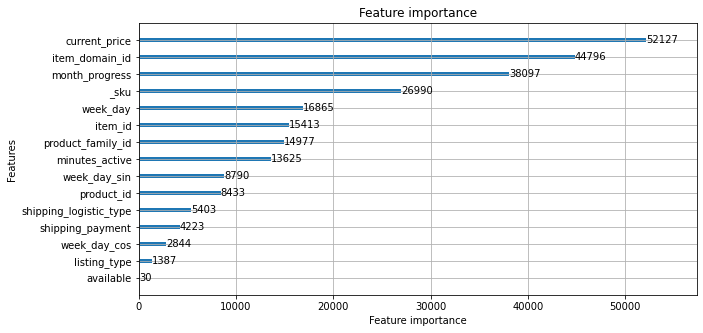

---------------------------------------------------------------------------
Training model for site: MLB
Mem. usage decreased to 956.01 Mb (40.9% reduction)
Mem. usage decreased to 657.94 Mb (51.0% reduction)
Elapsed time for processing features: 2.552258582909902 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 9392984, number of used features: 15
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.874767
[100]	valid_0's rmsse: 0.853811
[150]	valid_0's rmsse: 0.844645
[200]	valid_0's rmsse: 0.839325
[250]	valid_0's rmsse: 0.836653
[300]	valid_0's rmsse: 0.8346
[350]	valid_0's rmsse: 0.833258
[400]	valid_0's rmsse: 0.832352
[450]	valid_0's rmsse: 0.831698
[500]	valid_0's rmsse: 0.831169
[550]	valid_0's rmsse: 0.830841
[600]	valid_0's rmsse: 0.830523
[650]	valid_0's rmsse: 0.830275
[700]	valid_0's rmsse: 0.830048
[750]	valid_0's rmsse: 0.829841
[800]	valid_0's rmsse: 0.829708
[850]	valid_0's rmsse: 0.829637


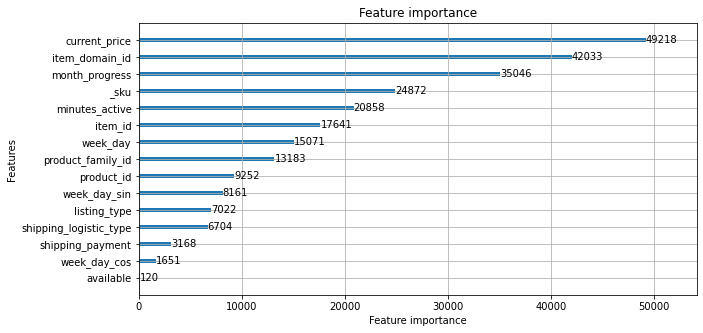

---------------------------------------------------------------------------
Training model for site: MLM
Mem. usage decreased to 823.12 Mb (38.9% reduction)
Mem. usage decreased to 520.47 Mb (51.0% reduction)
Elapsed time for processing features: 2.172875940799713 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 7430467, number of used features: 15
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.797557
[100]	valid_0's rmsse: 0.778918
[150]	valid_0's rmsse: 0.770984
[200]	valid_0's rmsse: 0.766371
[250]	valid_0's rmsse: 0.764343
[300]	valid_0's rmsse: 0.762722
[350]	valid_0's rmsse: 0.76175
[400]	valid_0's rmsse: 0.761238
[450]	valid_0's rmsse: 0.760935
[500]	valid_0's rmsse: 0.760622
[550]	valid_0's rmsse: 0.760372
[600]	valid_0's rmsse: 0.760197
[650]	valid_0's rmsse: 0.760051
Early stopping, best iteration is:
[664]	valid_0's rmsse: 0.76
Elapsed time for training the model: 6.619823515415192 min.


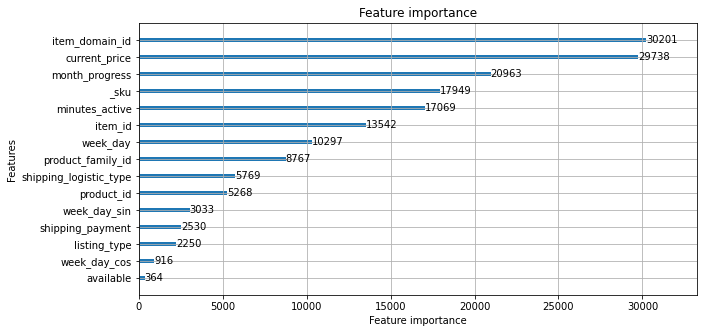

In [37]:
# train with huber
models_by_site = list()

for site in ["MLA","MLB","MLM"]:
    
    print("-"*75)
    print(f"Training model for site: {site}")
    model = LightGBMForecaster(**model_kwargs)

    tic = time.time()
    skus_both = set(dataset.query("ds <= '2021-03-01'").sku) & set(dataset.query("ds > '2021-03-01'").sku)
    train_data = dataset.query("site_id == @site & sku in @skus_both").reset_index(drop=True)
    valid_idx = train_data.query("ds > '2021-03-01'").index
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    lgb.plot_importance(model.model.model, figsize=(10,5))
    plt.show()

In [38]:
# results with huber
errors = list()
sites = ["MLA","MLB","MLM"]

for site,model in zip(sites,models_by_site):
    error = model.model.model.best_score["valid_0"]["rmsse"]
    errors.append(error)
    print(site, f"error: {error}")

print(f"AVG error: {np.mean(errors)}")

MLA error: 0.7735205832076515
MLB error: 0.8293535634630648
MLM error: 0.7600000151357996
AVG error: 0.7876247206021719


***

---------------------------------------------------------------------------
Training model for site: MLA
Mem. usage decreased to 149.01 Mb (43.3% reduction)
Mem. usage decreased to 112.77 Mb (51.0% reduction)
Elapsed time for processing features: 0.6072502772013346 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 1609906, number of used features: 15
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.780743
[100]	valid_0's rmsse: 0.7759
Early stopping, best iteration is:
[92]	valid_0's rmsse: 0.775525
Elapsed time for training the model: 0.48136518796284994 min.


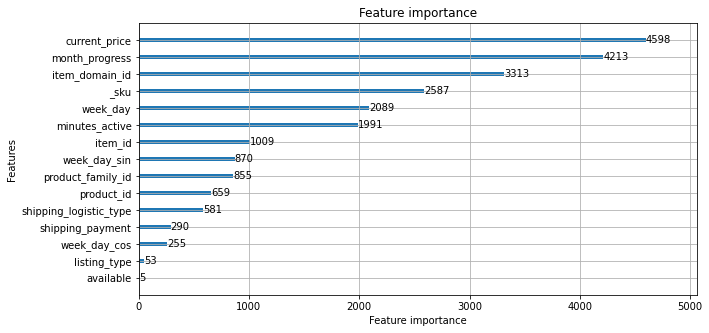

---------------------------------------------------------------------------
Training model for site: MLB
Mem. usage decreased to 956.01 Mb (40.9% reduction)
Mem. usage decreased to 657.94 Mb (51.0% reduction)
Elapsed time for processing features: 2.556572655836741 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 9392984, number of used features: 15
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.839332
[100]	valid_0's rmsse: 0.830306
Early stopping, best iteration is:
[112]	valid_0's rmsse: 0.829663
Elapsed time for training the model: 1.687638235092163 min.


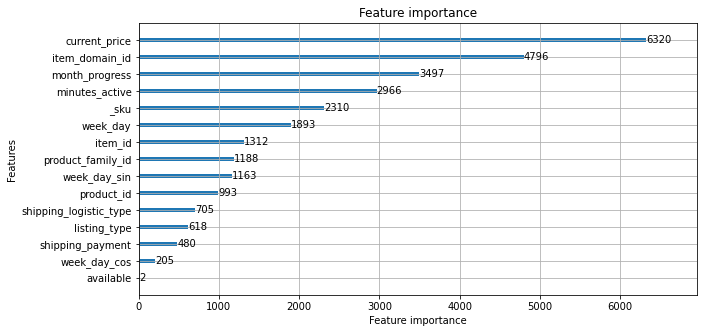

---------------------------------------------------------------------------
Training model for site: MLM
Mem. usage decreased to 823.12 Mb (38.9% reduction)
Mem. usage decreased to 520.47 Mb (51.0% reduction)
Elapsed time for processing features: 2.142014523347219 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 7430467, number of used features: 15
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.767345
Early stopping, best iteration is:
[60]	valid_0's rmsse: 0.76583
Elapsed time for training the model: 0.9647099574406942 min.


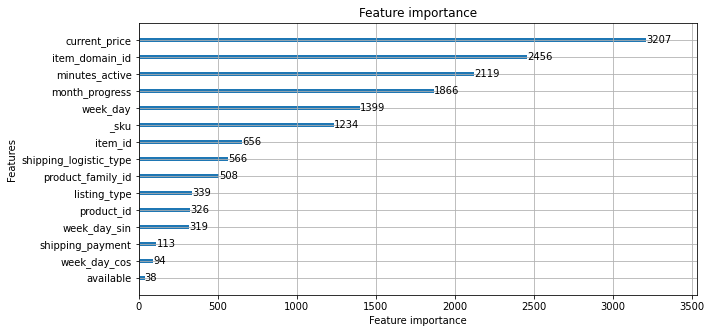

In [31]:
# train with l2
models_by_site = list()

for site in ["MLA","MLB","MLM"]:
    
    print("-"*75)
    print(f"Training model for site: {site}")
    model = LightGBMForecaster(**model_kwargs)

    tic = time.time()
    skus_both = set(dataset.query("ds <= '2021-03-01'").sku) & set(dataset.query("ds > '2021-03-01'").sku)
    train_data = dataset.query("site_id == @site & sku in @skus_both").reset_index(drop=True)
    valid_idx = train_data.query("ds > '2021-03-01'").index
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    lgb.plot_importance(model.model.model, figsize=(10,5))
    plt.show()


In [32]:
# results with l2
errors = list()
sites = ["MLA","MLB","MLM"]

for site,model in zip(sites,models_by_site):
    error = model.model.model.best_score["valid_0"]["rmsse"]
    errors.append(error)
    print(site, f"error: {error}")

print(f"AVG error: {np.mean(errors)}")

MLA error: 0.7755250918448042
MLB error: 0.8296625255176857
MLM error: 0.7658296593343581
AVG error: 0.7903390922322826


***

---------------------------------------------------------------------------
Training model for site: MLA
Mem. usage decreased to 149.01 Mb (43.3% reduction)
Mem. usage decreased to 112.77 Mb (51.0% reduction)
Elapsed time for processing features: 0.5960291862487793 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 1609906, number of used features: 15
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.839685
[100]	valid_0's rmsse: 0.784132
[150]	valid_0's rmsse: 0.779507
Early stopping, best iteration is:
[154]	valid_0's rmsse: 0.779419
Elapsed time for training the model: 0.7540865937868754 min.


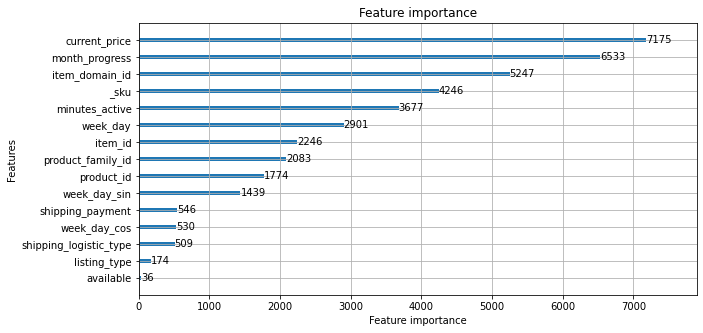

---------------------------------------------------------------------------
Training model for site: MLB
Mem. usage decreased to 956.01 Mb (40.9% reduction)
Mem. usage decreased to 657.94 Mb (51.0% reduction)
Elapsed time for processing features: 2.6164217988650003 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 9392984, number of used features: 15
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.897551
[100]	valid_0's rmsse: 0.838355
[150]	valid_0's rmsse: 0.833483
Early stopping, best iteration is:
[156]	valid_0's rmsse: 0.833369
Elapsed time for training the model: 2.3141193469365438 min.


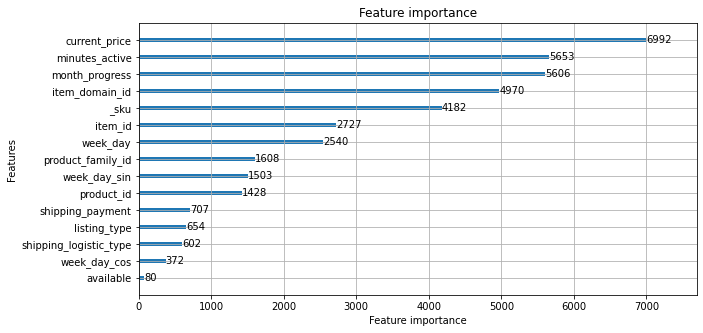

---------------------------------------------------------------------------
Training model for site: MLM
Mem. usage decreased to 823.12 Mb (38.9% reduction)
Mem. usage decreased to 520.47 Mb (51.0% reduction)
Elapsed time for processing features: 2.2009147723515827 min.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 7430467, number of used features: 15
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.843327
[100]	valid_0's rmsse: 0.782965
[150]	valid_0's rmsse: 0.777261
Early stopping, best iteration is:
[169]	valid_0's rmsse: 0.777046
Elapsed time for training the model: 2.0595929503440855 min.


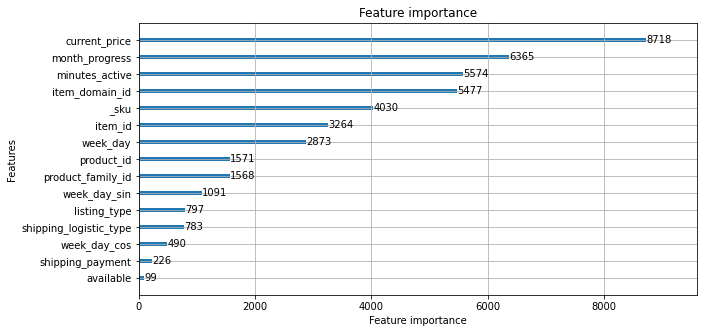

In [19]:
# train with tweedie (1.1)
models_by_site = list()

for site in ["MLA","MLB","MLM"]:
    
    print("-"*75)
    print(f"Training model for site: {site}")
    model = LightGBMForecaster(**model_kwargs)

    tic = time.time()
    skus_both = set(dataset.query("ds <= '2021-03-01'").sku) & set(dataset.query("ds > '2021-03-01'").sku)
    train_data = dataset.query("site_id == @site & sku in @skus_both").reset_index(drop=True)
    valid_idx = train_data.query("ds > '2021-03-01'").index
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    lgb.plot_importance(model.model.model, figsize=(10,5))
    plt.show()


In [28]:
# results with tweedie (1.1)
errors = list()
sites = ["MLA","MLB","MLM"]

for site,model in zip(sites,models_by_site):
    error = model.model.model.best_score["valid_0"]["rmsse"]
    errors.append(error)
    print(site, f"error: {error}")

print(f"AVG error: {np.mean(errors)}")

MLA error: 0.7794185580478147
MLB error: 0.8333694416663588
MLM error: 0.7770460756246792
AVG error: 0.7966113584462843


***
## Model training

In [ ]:
models_by_site = list()

for site in ["MLA","MLB","MLM"]:
    
    print("-"*75)
    print(f"Training model for site: {site}")
    model = LightGBMForecaster(**model_kwargs)

    tic = time.time()
    train_data = dataset.query("site_id == @site")
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit(fit_kwargs={"verbose_eval":50,})
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    lgb.plot_importance(model.model.model, figsize=(10,5))
    plt.show()

    break

***